In [46]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

In [47]:
np.random.seed(123)

boston = datasets.load_boston()
cancer =  datasets.load_breast_cancer()

In [50]:
X_boston = boston['data']
y_boston = boston['target']

X_cancer = cancer['data']
y_cancer = cancer['target']

# X_boston = normalize(X_boston)
# X_cancer = normalize(X_cancer)
X_boston = (X_boston-X_boston.mean(axis=0))/X_boston.std(axis=0)
X_cancer = (X_cancer-X_cancer.mean(axis=0))/X_cancer.std(axis=0)

In [51]:
X_boston_train, X_boston_test, y_boston_train, y_boston_test = train_test_split(X_boston, y_boston, test_size=0.25, random_state=0)
X_cancer_train, X_cancer_test, y_cancer_train, y_cancer_test = train_test_split(X_cancer, y_cancer, test_size=0.25, random_state=0)

In [52]:
## activation functions

def ReLU(h):
    return np.maximum(h, 0)

def sigmoid(h):
    return 1/(1+np.exp(-h))

def linear(h):
    return h

activation_function_dict = {
    'ReLU': ReLU,
    'sigmoid': sigmoid,
    'linear': linear
}

In [53]:
class FeedForwardNeuralNetwork:
    
    def fit(self, X, y, n_hidden, f1 = 'ReLU', f2 = 'linear', loss = 'RSS', lr = 1e-5, n_iter = 1e3, seed = None):
        
        ## Store Information
        self.X = X
        self.y = y.reshape(len(y), -1)
        self.N = len(X)
        self.D_X = self.X.shape[1]
        self.D_y = self.y.shape[1]
        self.D_h = n_hidden
        self.f1, self.f2 = f1, f2
        self.loss = loss
        self.lr = lr
        self.n_iter = int(n_iter)
        self.seed = seed
        
        ## Instantiate Weights
        np.random.seed(self.seed)
        self.W1 = np.random.randn(self.D_h, self.D_X)/5
        self.c1 = np.random.randn(self.D_h, 1)/5
        self.W2 = np.random.randn(self.D_y, self.D_h)/5
        self.c2 = np.random.randn(self.D_y, 1)/5
        
        ## Instantiate Outputs
        self.h1 = np.dot(self.W1, self.X.T) + self.c1
        self.z1 = activation_function_dict[f1](self.h1)
        self.h2 = np.dot(self.W2, self.z1) + self.c2
        self.yhat = activation_function_dict[f2](self.h2)
        
        ## Fit Weights
        for iteration in range(self.n_iter):
            
            dL_dW2 = 0
            dL_dc2 = 0
            dL_dW1 = 0
            dL_dc1 = 0
            
            for n in range(self.N):
                
                # dL_dyhat
                if loss == 'RSS':
                    dL_dyhat = -2*(self.y[n] - self.yhat[:,n]).T # (1, D_y)
                elif loss == 'log':
                    dL_dyhat = (-(self.y[n]/self.yhat[:,n]) + (1-self.y[n])/(1-self.yhat[:,n])).T # (1, D_y)
                
        
                ## LAYER 2 ## 
                # dyhat_dh2 
                if f2 == 'linear':
                    dyhat_dh2 = np.eye(self.D_y) # (D_y, D_y)
                elif f2 == 'sigmoid':
                    dyhat_dh2 = np.diag(sigmoid(self.h2[:,n])*(1-sigmoid(self.h2[:,n]))) # (D_y, D_y)
                    
                # dh2_dc2
                dh2_dc2 = np.eye(self.D_y) # (D_y, D_y)
                
                # dh2_dW2 
                dh2_dW2 = np.zeros((self.D_y, self.D_y, self.D_h)) # (D_y, (D_y, D_h)) 
                for i in range(self.D_y):
                    dh2_dW2[i] = self.z1[:,n] 
                
                # dh2_dz1
                dh2_dz1 = self.W2 # (D_y, D_h)
                
                
                ## LAYER 1 ##
                # dz1_dh1
                if f1 == 'ReLU':
                    dz1_dh1 = 1*np.diag(self.h1[:,n] > 0) # (D_h, D_h)                
                elif f1 == 'linear':
                    dz1_dh1 = np.eye(self.D_h) # (D_h, D_h)

                
                # dh1_dc1 
                dh1_dc1 = np.eye(self.D_h) # (D_h, D_h)
                
                # dh1_dW1
                dh1_dW1 = np.zeros((self.D_h, self.D_h, self.D_X)) # (D_h, (D_h, D_X))
                for i in range(self.D_h):
                    dh1_dW1[i] = self.X[n]
                
                
                ## DERIVATIVES W.R.T. LOSS ## 
                dL_dh2 = dL_dyhat @ dyhat_dh2
                dL_dW2 += dL_dh2 @ dh2_dW2
                dL_dc2 += dL_dh2 @ dh2_dc2
                dL_dh1 = dL_dh2 @ dh2_dz1 @ dz1_dh1
                dL_dW1 += dL_dh1 @ dh1_dW1
                dL_dc1 += dL_dh1 @ dh1_dc1
            
            ## Update Weights
            self.W1 -= self.lr * dL_dW1
            self.c1 -= self.lr * dL_dc1.reshape(-1, 1)           
            self.W2 -= self.lr * dL_dW2            
            self.c2 -= self.lr * dL_dc2.reshape(-1, 1)                    
            
            ## Update Outputs
            self.h1 = np.dot(self.W1, self.X.T) + self.c1
            self.z1 = activation_function_dict[f1](self.h1)
            self.h2 = np.dot(self.W2, self.z1) + self.c2
            self.yhat = activation_function_dict[f2](self.h2)
            
    def predict(self, X_test):
        self.h1 = np.dot(self.W1, X_test.T) + self.c1
        self.z1 = activation_function_dict[self.f1](self.h1)
        self.h2 = np.dot(self.W2, self.z1) + self.c2
        self.yhat = activation_function_dict[self.f2](self.h2)        
        return self.yhat
    

In [54]:
ffnn = FeedForwardNeuralNetwork()
ffnn.fit(X_boston_train, y_boston_train, n_hidden=8)
y_boston_test_hat = ffnn.predict(X_boston_test)

C:\Users\wilso\Anaconda3\envs\ia-tools\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


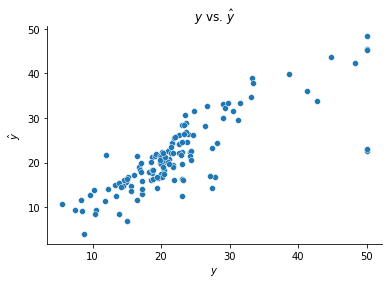

In [55]:
fig, ax = plt.subplots()
sns.scatterplot(y_boston_test, y_boston_test_hat[0])
ax.set(xlabel = r'$y$', ylabel = r'$\hat{y}$', title = r'$y$ vs. $\hat{y}$')
sns.despine()

In [56]:
ffnn = FeedForwardNeuralNetwork()
ffnn.fit(X_cancer_train, y_cancer_train, n_hidden = 8,
         loss = 'log', f2 = 'sigmoid', seed = 123, lr = 1e-4)
y_cancer_test_hat = ffnn.predict(X_cancer_test)
np.mean(y_cancer_test_hat.round() == y_cancer_test)

0.9300699300699301